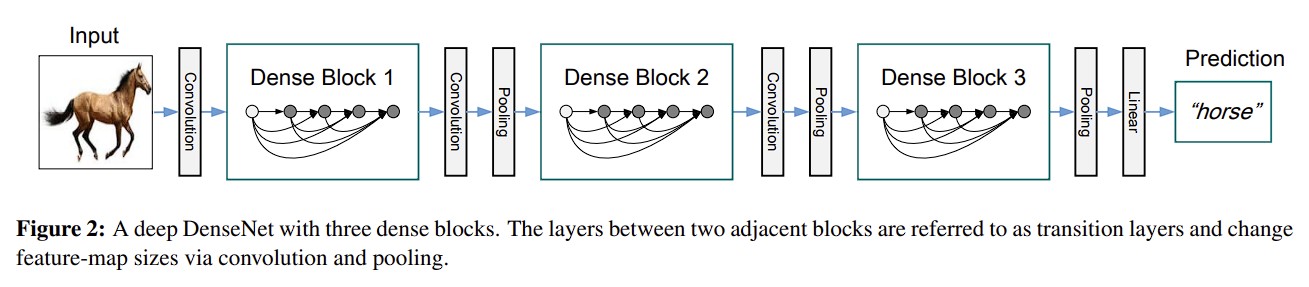

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
class Bottleneck_block(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        super(Bottleneck_block, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1, 
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.DropRate = drop_rate

    def forward(self, x):
        output = self.conv1(self.relu(self.bn1(x)))
        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        output = self.conv2(self.relu(self.bn2(output)))
        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        return torch.cat([x, output], 1)

In [3]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, 
                               padding=0,bias=False)
        self.DropRate = drop_rate
    def forward(self, x):
        output = self.conv1(self.relu(self.bn1(x)))

        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        return F.avg_pool2d(output, 2)

In [4]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, drop_rate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, drop_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate,drop_rate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [5]:
import math
class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12, reduction=0.5, drop_rate=0.0):
        super(DenseNet3, self).__init__()

        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        n = int(n/2)
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.block1 = DenseBlock(n, in_planes, growth_rate, Bottleneck_block, drop_rate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), drop_rate)
        in_planes = int(math.floor(in_planes*reduction))

        self.block2 = DenseBlock(n, in_planes, growth_rate, Bottleneck_block, drop_rate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), drop_rate)
        in_planes = int(math.floor(in_planes*reduction))

        self.block3 = DenseBlock(n , in_planes, growth_rate, Bottleneck_block,drop_rate)
        in_planes = int(in_planes+n*growth_rate)

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes
        #weight initialization ig
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # Kaiming Initialization
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        output = self.conv1(x)
        output = self.trans1(self.block1(output))
        output = self.trans2(self.block2(output))
        output = self.block3(output)
        output = self.relu(output)
        output = F.avg_pool2d(output, 8)
        output = output.view(-1, self.in_planes)
        return self.fc(output)

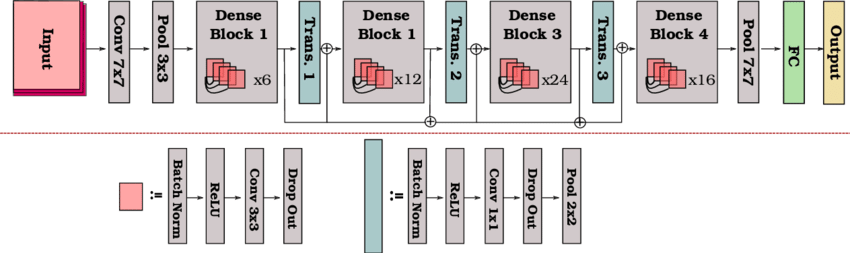

In [6]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=100, growth_rate=32, reduction=0.5, drop_rate=0.0):
        super(DenseNet121, self).__init__()
         
        block_config = [6, 12, 24, 16]
        in_planes = 2 * growth_rate
        
        self.features = nn.Sequential(
            nn.Conv2d(3, in_planes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(in_planes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.dense_blocks = nn.ModuleList()
        self.trans_blocks = nn.ModuleList()

        for i, num_layers in enumerate(block_config):
            dense_block = DenseBlock(num_layers, in_planes, growth_rate, Bottleneck_block, drop_rate)
            self.dense_blocks.append(dense_block)
            in_planes =  in_planes + num_layers * growth_rate

            if i != len(block_config) - 1:
                out_planes = int(in_planes * reduction)
                trans_block = TransitionBlock(in_planes, out_planes, drop_rate)
                self.trans_blocks.append(trans_block)
                in_planes = out_planes
        self.bn = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_planes, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # Kaiming Initialization
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        output = self.features(x)
        for i in range(len(self.dense_blocks)):
            output = self.dense_blocks[i](output)
            if i < len(self.trans_blocks):
                output = self.trans_blocks[i](output)
        output = self.relu(self.bn(output))
        output = self.avg_pool(output)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        return output

In [7]:
model = DenseNet121(num_classes=100, growth_rate=32, reduction=0.5, drop_rate=0.2)

In [8]:
x = torch.randn(256, 3, 32, 32)  

In [9]:
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([256, 100])


In [10]:
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [12]:
from torchvision.transforms import v2
train_transforms = v2.Compose([
    v2.RandomCrop(size=(32, 32)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

c:\Users\blade\anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [13]:
from torchinfo import summary
summary(model, input_size=(256, 3, 32, 32)) 

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet121                                   [256, 100]                --
├─Sequential: 1-1                             [256, 64, 8, 8]           --
│    └─Conv2d: 2-1                            [256, 64, 16, 16]         9,408
│    └─BatchNorm2d: 2-2                       [256, 64, 16, 16]         128
│    └─ReLU: 2-3                              [256, 64, 16, 16]         --
│    └─MaxPool2d: 2-4                         [256, 64, 8, 8]           --
├─ModuleList: 1-8                             --                        (recursive)
│    └─DenseBlock: 2-5                        [256, 256, 8, 8]          --
│    │    └─Sequential: 3-1                   [256, 256, 8, 8]          335,040
├─ModuleList: 1-7                             --                        (recursive)
│    └─TransitionBlock: 2-6                   [256, 128, 4, 4]          --
│    │    └─BatchNorm2d: 3-2                  [256, 256, 8, 8]      

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [15]:
from pytorch_model_train import train_model

In [16]:
model, history = train_model(model, criterion, optimizer, scheduler,train_loader, test_loader, device, 50)

Epoch 1/50
--------------------------------------------------
[Epoch 1/50] Train Loss: 4.4498 | Train Acc: 4.08%
[Epoch 1/50] Val   Loss: 4.0736 | Val   Acc: 8.10%

Epoch 2/50
--------------------------------------------------
[Epoch 2/50] Train Loss: 3.9473 | Train Acc: 9.52%
[Epoch 2/50] Val   Loss: 3.7654 | Val   Acc: 13.29%

Epoch 3/50
--------------------------------------------------
[Epoch 3/50] Train Loss: 3.5971 | Train Acc: 14.45%
[Epoch 3/50] Val   Loss: 3.4251 | Val   Acc: 16.57%

Epoch 4/50
--------------------------------------------------
[Epoch 4/50] Train Loss: 3.3216 | Train Acc: 19.17%
[Epoch 4/50] Val   Loss: 3.1162 | Val   Acc: 23.10%

Epoch 5/50
--------------------------------------------------
[Epoch 5/50] Train Loss: 3.1263 | Train Acc: 22.63%
[Epoch 5/50] Val   Loss: 3.0577 | Val   Acc: 25.03%

Epoch 6/50
--------------------------------------------------
[Epoch 6/50] Train Loss: 2.9418 | Train Acc: 25.94%
[Epoch 6/50] Val   Loss: 2.8867 | Val   Acc: 27.49%

E